In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')

sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
# import munkres
# reload(munkres)
from munkres import munkres

# https://github.com/jfrelinger/cython-munkres-wrapper,
# 10 times faster than the python implementation http://software.clapper.org/munkres/

# from munkres import Munkres # http://software.clapper.org/munkres/

In [443]:
sys.path.append('/home/yuncong/Brain/pipeline_scripts')
import utilities2014
reload(utilities2014)
from utilities2014 import *

In [4]:
import os
import time

# os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
# os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
# os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
# os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram, ward

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filter.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline


stack_name = 'RS140'

In [5]:
# Order the exterior by depth-first search
# The ordering is not well-defined in some corners

def find_boundary_sps(clusters, neighbors, neighbor_graph):
    '''
    Identify superpixels that are at the boundary of regions: surround set and frontier set
    
    Parameters
    ----------
    clusters : list of integer lists
    neighbors : neighbor_list
    neighbor_graph : 
    '''
        
    n_superpixels = len(clusters)
    
    surrounds_sps = []
    frontiers_sps = []
    
    for cluster_ind, cluster in enumerate(clusters):
        
        surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
#         surrounds = set([i for i in surrounds if any([(n not in cluster) and (n not in surrounds) for n in neighbors[i]])])
        surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

        if len(surrounds) == 0:
            surrounds_sps.append([])
            frontiers_sps.append([])

        else:
            frontiers = set.union(*[neighbors[c] for c in surrounds]) & set(cluster)

            surrounds_subgraph = neighbor_graph.subgraph(surrounds)
            surrounds_traversal = list(dfs_postorder_nodes(surrounds_subgraph))

            frontiers_subgraph = neighbor_graph.subgraph(frontiers)
            frontiers_traversal = list(dfs_postorder_nodes(frontiers_subgraph))

            surrounds_sps.append(surrounds_traversal)
            frontiers_sps.append(frontiers_traversal)
        
    return surrounds_sps, frontiers_sps

In [6]:
def compute_overlap(c1, c2):
    return float(len(c1 & c2)) / min(len(c1),len(c2))

def compute_overlap2(c1, c2):
    return float(len(c1 & c2)) / len(c1 | c2)    

def compute_overlap_partial(indices, sets, metric='jaccard'):
    n_sets = len(sets)
    
    overlap_matrix = np.zeros((len(indices), n_sets))
        
    for ii, i in enumerate(indices):
        for j in range(n_sets):
            c1 = set(sets[i])
            c2 = set(sets[j])
            if len(c1) == 0 or len(c2) == 0:
                overlap_matrix[ii, j] = 0
            else:
                if metric == 'min-jaccard':
                    overlap_matrix[ii, j] = compute_overlap(c1, c2)
                elif metric == 'jaccard':
                    overlap_matrix[ii, j] = compute_overlap2(c1, c2)
                else:
                    raise Exception('metric %s is unknown'%metric)
            
    return overlap_matrix

def set_pairwise_distances(sets, metric):

    partial_overlap_mat = Parallel(n_jobs=16, max_nbytes=1e6)(delayed(compute_overlap_partial)(s, sets, metric=metric) 
                                        for s in np.array_split(range(len(sets)), 16))
    overlap_matrix = np.vstack(partial_overlap_mat)
    distance_matrix = 1 - overlap_matrix
    
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix



def group_clusters(clusters=None, dist_thresh = 0.1, distance_matrix=None, metric='jaccard',
                  returnD=False, linkage='complete'):

    if distance_matrix is None:
        assert clusters is not None
        distance_matrix = set_pairwise_distances(clusters, metric)
        
    if linkage=='complete':
        lk = complete(squareform(distance_matrix))
    elif linkage=='average':
        lk = average(squareform(distance_matrix))
    elif linkage=='single':
        lk = single(squareform(distance_matrix))


    # T = fcluster(lk, 1.15, criterion='inconsistent')
    T = fcluster(lk, dist_thresh, criterion='distance')
    
    n_groups = len(set(T))
    groups = [None] * n_groups

    for group_id in range(n_groups):
        groups[group_id] = np.where(T == group_id+1)[0]

    if returnD:
        return [g for g in groups if len(g) > 0], distance_matrix
    else:
        return [g for g in groups if len(g) > 0]


In [7]:
# def detect_open_boundaries(sec_ind):
    
#     dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec_ind)
    
#     # Load image and relevant data
#     im_height, im_width = imread(dm._get_image_filepath()).shape[:2]

#     texton_hists = dm.load_pipeline_result('texHist', 'npy')
#     segmentation = dm.load_pipeline_result('segmentation', 'npy')
#     n_superpixels = len(np.unique(segmentation)) - 1
#     textonmap = dm.load_pipeline_result('texMap', 'npy')
#     n_texton = len(np.unique(textonmap)) - 1
#     neighbors = dm.load_pipeline_result('neighbors', 'npy')
#     sp_properties = dm.load_pipeline_result('spProps', 'npy')
#     segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

#     # Load region proposals
#     expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
#     expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
#     expansion_cluster_scores = np.array(expansion_cluster_scores)

#     neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
#     neighbor_graph = from_dict_of_lists(neighbors_dict)
        
#     surrounds_sps, frontiers_sps = find_boundary_sps(expansion_clusters, neighbors=neighbors, neighbor_graph=neighbor_graph)
    
    
#     # votes for directed edgelets
#     dEdge_votes = defaultdict(int)
    
#     # Compute the supporter sets of every edgelet, based on region proposals
#     # supporter_all[(100,101)] is the set of superpixels that supports directed edgelet (100,101)
#     supporters_all = defaultdict(list)

#     for s in range(n_superpixels):
#     #     if s not in sps_in_good_regions: continue

#         c = list(expansion_clusters[s])
#         interior_texture = texton_hists[c].mean(axis=0)
#         b_sps = surrounds_sps[s]
#         b_contrasts = cdist(texton_hists[b_sps], interior_texture[np.newaxis, :], chi2)

#         for b_sp, b_contrast in zip(b_sps, b_contrasts):
#             int_sps = neighbors[b_sp] & set(c)
#             for int_sp in int_sps:
#                 dEdge_votes[(b_sp, int_sp)] += b_contrast / max(len(c), 5)
#                 dEdge_votes[(int_sp, b_sp)] += b_contrast / max(len(c), 5)
#                 supporters_all[(b_sp, int_sp)].append(s) # (border_sp, interior_sp) or (out, in)
    
#     edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')
    
#     # threshold the edgelet votes
#     dEdge_vote_thresh = 1.
#     winner_dEdges = [dedge for dedge, v in dEdge_votes.iteritems() if v > dEdge_vote_thresh]
    
#     # group the winning edgelets, according to their supporter sets
#     winner_supporters = [supporters_all[dedge] for dedge in winner_dEdges]
#     supporter_D = set_pairwise_distances(winner_supporters, metric=1)
#     supporter_sim_thresh = .2
#     winner_indices_grouped_by_supporters = group_clusters(winner_supporters, dist_thresh=supporter_sim_thresh, 
#                                                           distance_matrix=supporter_D)
# #     print len(winner_indices_grouped_by_supporters), 'alliances'
#     winners_grouped_by_supporters = [[winner_dEdges[i] for i in g] for g in winner_indices_grouped_by_supporters]
    
#     alliance_sizes = np.array(map(len, winners_grouped_by_supporters))

#     # pick edgelet groups with more than 20 edgelets
#     big_alliance_indices = np.where(alliance_sizes > 20)[0]
# #     print len(big_alliance_indices), 'big alliances'
#     big_alliance_dEdges = [winners_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
#     big_alliance_winnerIndices = [winner_indices_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
#     big_alliance_supporters = [set.union(*[set(winner_supporters[i]) for i in a]) for a in big_alliance_winnerIndices]
#     # define supporter set of an edgelet group as the union of each supporter set

#     # sort edgelet groups by total vote over all edgelets
#     good_edgeSet_tuple_sorted_by_score = sorted([(np.sum([dEdge_votes[e] for e in edges]), edges, alliance_ind)
#                                                       for alliance_ind, edges in enumerate(big_alliance_dEdges)
#                                                       if len(edges) > 10], reverse=True)
#     good_edgeSet_scores_sorted, good_edgeSets_sorted, good_edgeSet_indices_sorted = zip(*good_edgeSet_tuple_sorted_by_score)  
#     good_edgeSet_supporters = [ big_alliance_supporters[alliance_i] for alliance_i in good_edgeSet_indices_sorted]
#     # give this to Idan's web interface
    
# #     print len(good_edgeSet_tuple_sorted_by_score), 'good boundaries'
    
#     # These edgelet groups constitute Open Boundary landmarks.
    
#     vis = dm.visualize_edge_sets(good_edgeSets_sorted[:10])
#     dm.save_pipeline_result(vis, 'openBoundariesTop10', 'jpg')
    
#     dm.save_pipeline_result(good_edgeSet_tuple_sorted_by_score, 'openBoundaries', 'pkl')
#     dm.save_pipeline_result(good_edgeSet_supporters, 'openBoundariesSupporters', 'pkl')

In [8]:
def combine_two_landmark_types(sec_ind):
    
    dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec_ind)
    texton_hists = dm.load_pipeline_result('texHist', 'npy')
    edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')
    
    # Load closed region landmarks
    representative_clusters = dm.load_pipeline_result('representativeClusters', 'pkl')

    representative_cluster_scores_sorted, representative_clusters_sorted_by_score, \
    representative_cluster_indices_sorted_by_score, big_groups_sorted_by_score = zip(*representative_clusters)

    closedRegion_edgeSets_sorted_by_score = dm.load_pipeline_result('closedRegionsTop30Edgesets', 'pkl')

    # Load open boundary landmarks
    openBoundaries = dm.load_pipeline_result('openBoundaries', 'pkl')
    
    openBoundaries_scores_sorted, openBoundaries_edgeSets_sorted_by_score, \
    openBoundaries_indices_sorted_by_score = zip(*openBoundaries)
    
    openBoundaries_supporters = dm.load_pipeline_result('openBoundariesSupporters', 'pkl')

    
    # Select top 30 Closed Boundary landmarks and top 10 Open Boundary landmarks
    all_edgeSets = list(chain(*[closedRegion_edgeSets_sorted_by_score, 
                                openBoundaries_edgeSets_sorted_by_score[:10]]))
    all_scores = list(chain(*[representative_cluster_scores_sorted, 
                                openBoundaries_scores_sorted[:10]]))

    lm_types = np.r_[np.zeros((len(closedRegion_edgeSets_sorted_by_score),)), 
                    np.ones((10,))]
    
    # Represent each landmark with a tuple
    # (edgeSet, interior_texture, exterior_textures, points, center, supporter_set(?))
    boundary_models = []

    all_supporters = list(representative_clusters_sorted_by_score[:30]) + list(openBoundaries_supporters[:10])
    #     dm.save_pipeline_result(lm_supporters, 'supporters', 'pkl')

#     overlapping_boundary_groups, D = group_clusters(all_supporters, dist_thresh = 0.1, metric=2,
#                                                 returnD=True)
    overlapping_boundary_groups, D = group_clusters(all_edgeSets, dist_thresh = 0.6, metric=1,
                                                returnD=True)
    
    # select the landmark with the largest supporter set to represent each group (may need a better idea)
    # using score is meaningless if comparison is between different types.
    nonoverlapping_lm_indices = [c[np.argmax([len(all_supporters[i]) for i in c])] for c in overlapping_boundary_groups]
#     print overlapping_boundary_groups
#     print nonoverlapping_lm_indices

    nonoverlapping_scores = [all_scores[i] for i in nonoverlapping_lm_indices]
    
    nonoverlapping_edgeSets = [all_edgeSets[i] for i in nonoverlapping_lm_indices]    
    nonoverlapping_lm_supporters = [all_supporters[i] for i in nonoverlapping_lm_indices]
    nonoverlapping_lm_types = [lm_types[i] for i in nonoverlapping_lm_indices]
    
    order = np.argsort(nonoverlapping_scores)[::-1]
    
    nonoverlapping_edgeSets_sorted_by_score = [nonoverlapping_edgeSets[i] for i in order]
    nonoverlapping_lm_supporters_sorted_by_score = [nonoverlapping_lm_supporters[i] for i in order]
    nonoverlapping_lm_types_sorted_by_score = [nonoverlapping_lm_types[i] for i in order]

    #     dm.save_pipeline_result(nonoverlapping_lm_supporters, 'nonoverlappingSupporters', 'pkl')

    #     for edgeSet_ind, edgeSet in zip(good_edgeSet_indices_sorted, good_edgeSets_sorted):

    interior_superpixels = []
    for edgeSet, spptrs, lm_type in zip(nonoverlapping_edgeSets_sorted_by_score, 
                                        nonoverlapping_lm_supporters_sorted_by_score, 
                                        nonoverlapping_lm_types_sorted_by_score):

        # interior_texture = texton_hists[list(big_alliance_supporters[edgeSet_ind])].mean(axis=0)

        surrounds = [e[0] for e in edgeSet]
        frontiers = [e[1] for e in edgeSet]

        if lm_type == 1: # OpenBoundaries
            interior_texture = texton_hists[frontiers].mean(axis=0)
            interior_superpixels.append(list(set(frontiers)))
        else: # CloseRegions
            interior_texture = texton_hists[list(spptrs)].mean(axis=0)
            interior_superpixels.append(list(set(spptrs)))
            
        exterior_textures = np.array([texton_hists[s] if s!=-1 else np.nan * np.ones((texton_hists.shape[1],)) for s in surrounds])
        # how to deal with -1 in surrounds? Assign to an all np.nan vector
        
        points = np.array([edge_coords[frozenset(e)].mean(axis=0) for e in edgeSet])

        center = points.mean(axis=0)

        boundary_models.append((edgeSet, interior_texture, exterior_textures, points, center))
        
    dm.save_pipeline_result(boundary_models, 'boundaryModels', 'pkl')
    dm.save_pipeline_result(nonoverlapping_lm_types_sorted_by_score, 'nonoverlapLmTypes', 'npy')
    dm.save_pipeline_result(interior_superpixels, 'internalSps', 'pkl')
    
#     return all_edgeSets, D
    

In [9]:
def generate_boundary_visualizations(sec):
    '''
    Generate visualization for boundaries of sec. 
    '''
    
    dm = DataManager(generate_hierarchy=False, stack=stack_name, resol='x5', section=sec)
    
    boundaries = dm.load_pipeline_result('boundaryModels', 'pkl')

    # Save output
    for i, b in enumerate(boundaries):
        dm.save_pipeline_result(dm.visualize_edges(b[0], text=False, color=[0,255,0]), 'boundary%02d'%i, 'jpg')
    
    vis = dm.visualize_edge_sets([b[0] for b in boundaries], text=False)
    dm.save_pipeline_result(vis, 'allBoundaries', 'jpg')
    
    vis = dm.visualize_edge_sets([b[0] for b in boundaries], text=True)
    dm.save_pipeline_result(vis, 'allBoundariesWithLabel', 'jpg')
    

In [10]:
from subprocess import check_output
s = check_output("ssh gordon.sdsc.edu ls %s" % os.path.join(os.environ['GORDON_DATA_DIR'], stack_name, 'x5'), shell=True)
slide_indices = [int(f) for f in s.split('\n') if len(f) > 0]

In [444]:
# def detect_open_boundaries(sec_ind):
    
dm = DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=7)
dm._load_image()

# Load image and relevant data
im_height, im_width = imread(dm._get_image_filepath()).shape[:2]

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1
neighbors = dm.load_pipeline_result('neighbors', 'pkl')
sp_properties = dm.load_pipeline_result('spProps', 'npy')
segmentation_vis = dm.load_pipeline_result('segmentationWithText', 'jpg')

# Load region proposals
expansion_clusters_tuples = dm.load_pipeline_result('clusters', 'pkl')
expansion_clusters, expansion_cluster_scores = zip(*expansion_clusters_tuples)
expansion_cluster_scores = np.array(expansion_cluster_scores)

neighbors_dict = dict(zip(np.arange(n_superpixels), [list(i) for i in neighbors]))
neighbor_graph = from_dict_of_lists(neighbors_dict)

surrounds_sps, frontiers_sps = find_boundary_sps(expansion_clusters, neighbors=neighbors, neighbor_graph=neighbor_graph)


In [12]:
# votes for directed edgelets
dedge_vote_dict = defaultdict(float)

# Compute the supporter sets of every edgelet, based on region proposals
# supporter_all[(100,101)] is the set of superpixels that supports directed edgelet (100,101)
dedge_supporters = defaultdict(list)

for s in range(n_superpixels):
#     if s not in sps_in_good_regions: continue

    c = list(expansion_clusters[s])
    interior_texture = texton_hists[c].mean(axis=0)
    b_sps = surrounds_sps[s]
    b_contrasts = cdist(texton_hists[b_sps], interior_texture[np.newaxis, :], chi2)

    for b_sp, b_contrast in zip(b_sps, b_contrasts):
        int_sps = neighbors[b_sp] & set(expansion_clusters[s])
        for int_sp in int_sps:
            # weight of each edgelet is the contrast normalized by region size
#             weight = float(b_contrast) / max(len(c), 5)
#             weight = 1. / max(len(c), 5)
            weight = 1.
            dedge_vote_dict[(b_sp, int_sp)] += weight
#             dedge_vote_dict[(int_sp, b_sp)] += weight
            dedge_supporters[(b_sp, int_sp)].append(s) # (border_sp, interior_sp) or (out, in)

# edge_coords = dm.load_pipeline_result('edgeCoords', 'pkl')

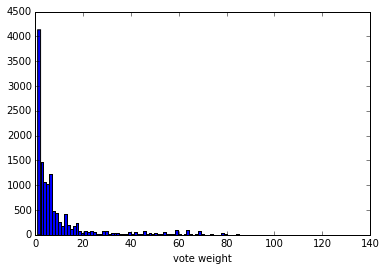

In [13]:
plt.hist(dedge_vote_dict.values(), bins=100);
plt.xlabel('vote weight');

In [15]:
edge_coords = dict(dm.load_pipeline_result('edgeCoords', 'pkl'))

In [ ]:
# cluster_dist_mat = set_pairwise_distances(expansion_clusters, metric=2)
# sp_groups_by_expansion_regions = group_clusters(dist_thresh=.8, distance_matrix=cluster_dist_mat)

In [18]:
import networkx as nx
from itertools import chain

In [30]:
dedge_neighbors = dict([(de, set(chain(*[[(i,j),(j,i)] 
                                          for i,j in edge_neighbors[frozenset(de)]]))) 
                        for de in dedges])

In [28]:
nz_dedges = dedge_vote_dict.keys()

In [29]:
nz_dedge_supporters = [supporters_all[de] for de in nz_dedges]
nz_dedge_dist_mat_minjac = set_pairwise_distances(nz_dedge_supporters, metric='min-jaccard')
nz_dedge_assoc_mat_minjac = 1. - nz_dedge_dist_mat_minjac

In [37]:
nz_dedge_connecitivity_mat = np.zeros((len(nz_dedges), len(nz_dedges)))
nz_dedge_neighbors = dict([])
for dei, de in enumerate(nz_dedges):    
    des = dedge_neighbors[de] & set(nz_dedges)
    nz_dedge_connecitivity_mat[dei, [nz_dedges.index(e) for e in des]] = 1
    
np.fill_diagonal(nz_dedge_connecitivity_mat, 1)

In [161]:
nz_dedge_mat = (nz_dedge_assoc_mat_minjac > .99).astype(np.bool) & nz_dedge_connecitivity_mat.astype(np.bool)

In [162]:
nz_G = nx.Graph(nz_dedge_mat)

In [296]:
q = nx.node_connected_component(nz_G, (1864,1939))

In [263]:
nz_G = nx.relabel_nodes(nz_G, dict(enumerate(nz_dedges)))

In [312]:
display(dm.visualize_edge_sets([q], 
                               img=segmentation_vis, directed=True, text_size=3,
                              neighbors=nz_G.adj))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [269]:
dEdge_votes = dict(dEdge_votes)

In [123]:
nz_dedge_mat_float = nz_dedge_mat.astype(np.float)
nz_dedge_mat_row_normalized = nz_dedge_mat_float/nz_dedge_mat_float.sum(axis=1)[:,np.newaxis]

In [27]:
def visualize_dedge_vote(vote_dict, vote_thresh=0, bg=False):

    img_edge = np.zeros_like(dm.image_rgb, np.float)
    img_edge_alpha = np.zeros_like(dm.image, np.float)
    for edge, s in vote_dict.iteritems():
        if s > vote_thresh:
            cs = edge_coords[frozenset(edge)]
            img_edge[cs[:,0], cs[:,1]] = (1.,0,0)
            img_edge_alpha[cs[:,0], cs[:,1]] = s

    img_edge_alpha = (img_edge_alpha-img_edge_alpha.min())/(img_edge_alpha.max()-img_edge_alpha.min())
    
    if bg:
        img_highvote = alpha_blending(img_as_float(gray2rgb(dm.image)), img_edge, 
                                      .2 * np.ones_like(dm.image), .8 * img_edge_alpha)
        img_highvote[~dm.mask] = 0.
        return img_highvote
    else:
        return img_edge_alpha

In [28]:
dedge_vote_thresh = np.sort(dedge_vote_dict.values())[-.2*len(dedge_vote_dict)]
print dedge_vote_thresh

display(visualize_dedge_vote(dedge_vote_dict, bg=True, vote_thresh=dedge_vote_thresh))

12.0


/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:107: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [29]:
display(visualize_dedge_vote(dedge_vote_dict, bg=True, vote_thresh=0))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [19]:
def spSet_to_edgeSet(cluster, n_superpixels, neighbors=None, fill_holes=False):

    
    if neighbors is None:
        neighbors = neighbors_global

    
    cluster = set(cluster)
    
    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

    if fill_holes:    
        outside = set(range(n_superpixels)) - cluster - surrounds
        hole_candidates = set(range(n_superpixels)) - cluster
    
        goon = True
        while goon:
            goon = False
            for hc in hole_candidates - outside:
                if any([s in outside for s in neighbors[hc]]):
        #             print hc
                    outside.add(hc)
                    goon = True

        holes = set(range(n_superpixels)) - outside - cluster
    #     print holes

        cluster = set(cluster) | holes

    surrounds = set([i for i in set.union(*[neighbors[c] for c in cluster]) if i not in cluster and i != -1])
    surrounds = set([i for i in surrounds if any([n not in cluster for n in neighbors[i]])])

    # only happen in island node
    if len(surrounds) == 0:
        return []
    else:
        frontiers = set.union(*[neighbors[c] for c in surrounds]) & set(cluster)    

    region_edges = []
    for s in surrounds:
        for f in neighbors[s] & set(frontiers):
            region_edges.append((s, f))

    for i in cluster:
        if -1 in neighbors[i]:
            region_edges.append((-1, i))

    return sorted(region_edges)

In [20]:
neighbors_global = neighbors

In [22]:
all_edges = edge_coords.keys()
all_dedges = set(chain(*[[(i,j),(j,i)] for i,j in all_edges]))

In [23]:
def f(c):
    q = set(chain(*[[(i,j),(j,i)] for i,j in combinations(c, 2) if frozenset([i,j]) in all_edges]))
    s = set(spSet_to_edgeSet(c, n_superpixels))
    return q | s

In [24]:
contain_edges = Parallel(n_jobs=16)(delayed(f)(c) for c in expansion_clusters)

In [25]:
edge_contained_by = defaultdict(set)
for sp, es in enumerate(contain_edges):
    for e in es:
        edge_contained_by[e].add(sp)

edge_contained_by.default_factory = None

In [30]:
nz_dedges = dedge_vote_dict.keys()

In [32]:
# dedge_contrast = dict([((i,j), chi2(texton_hists[i], texton_hists[j])) for i,j in all_dedges])
dedge_contrast = dict([((i,j), chi2(texton_hists[i], texton_hists[dedge_supporters[(i,j)]].mean(axis=0))) 
                       for i,j in all_dedges])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/core/_methods.py:69: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


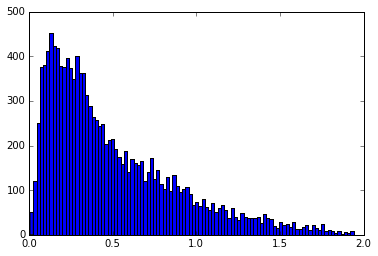

In [451]:
plt.hist(filter(lambda x: not np.isnan(x), dedge_contrast.values()), bins=100);

In [33]:
nz_dedges2 = [e for e,sps in edge_contained_by.iteritems() if len(sps) > 3]
nz_dedges2 = [e for e in nz_dedges2 if dedge_contrast[e] > .5]
dedge_stopperness = dict([(e, dedge_vote_dict[e]/len(edge_contained_by[e])) for e in nz_dedges2])
nz_dedges2 = [e for e in nz_dedges2 if dedge_stopperness[e] == 1.]

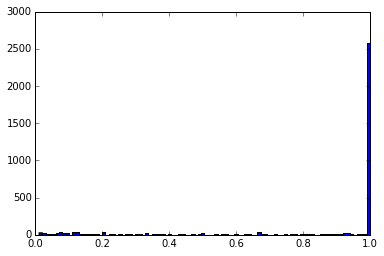

In [34]:
plt.hist(dedge_stopperness.values(), bins=100);

In [44]:
display(visualize_dedge_vote(dedge_stopperness, vote_thresh=.9999, bg=True))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [36]:
good_edge_supporter_dist_mat_minjac = set_pairwise_distances([dedge_supporters[e] for e in nz_dedges2], 
                                                             metric='min-jaccard')

In [426]:
import networkx as nx
Q = nx.Graph((1. - good_edge_supporter_dist_mat_minjac) >= .9)
Q = nx.relabel_nodes(Q, dict(enumerate(nz_dedges2)))

# option 1
# cliques = list(nx.clique.find_cliques(Q))

# option 2
# cliques = list(nx.community.k_clique_communities(Q,10))

# option 3
cliques = list(nx.clique.find_cliques(Q))
cliques = [c for c in cliques if len(c) > 10]

print len(cliques)

159


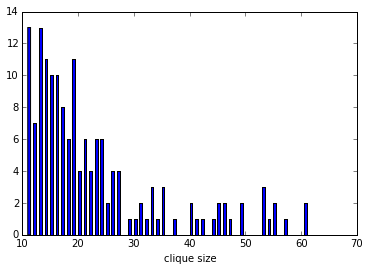

In [359]:
plt.hist(map(len, cliques), bins=100);
plt.xlabel('clique size');

In [401]:
from collections import Counter
clique_counters = [Counter(chain(*[dedge_supporters[e] for e in es])) for es in cliques]
clique_supporters = [set([s for s, c in cc.iteritems() if c > (cc.most_common(1)[0][1]*.3)]) for cc in clique_counters]

# clique_supporters = [set.intersection(*[set(dedge_supporters[e]) for e in es]) for es in cliques]

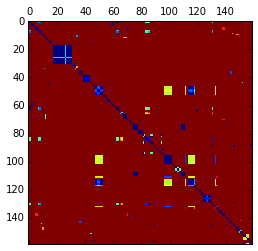

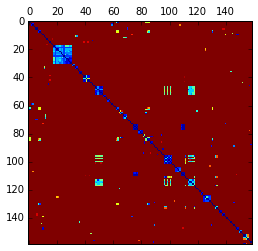

In [368]:
plt.matshow(clique_supporter_distance_mat);
plt.show();
plt.matshow(clique_edge_distance_mat);
plt.show();

In [460]:
clique_supporter_distance_mat = set_pairwise_distances(clique_supporters, metric='jaccard')
clique_edge_distance_mat = set_pairwise_distances(cliques, metric='min-jaccard')

clique_distance_mat = np.minimum(clique_supporter_distance_mat, clique_edge_distance_mat)

cliques_grouped_by_overlap = group_clusters(dist_thresh=.25, 
                                            distance_matrix=clique_distance_mat,
                                            linkage='complete')

print len(cliques_grouped_by_overlap)

82


In [461]:
cliques_indices_noduplicate = [g[np.argmax([len(cliques[e]) for e in g])] for g in cliques_grouped_by_overlap]
cliques_noduplicate = [cliques[i] for i in cliques_indices_noduplicate]

In [352]:
cliques_noduplicate = cliques

In [462]:
clique_sorted_by_size = sorted(cliques_noduplicate, 
                               key=lambda es: sum([len(edge_coords[frozenset(e)]) for e in es]), 
                               reverse=True)

In [463]:
clique_sorted_by_stopperness = sorted(cliques_noduplicate, 
                               key=lambda es: np.sum([dedge_stopperness[e] for e in es]), 
                               reverse=True)

In [459]:
i1 = cliques_indices_noduplicate[cliques_noduplicate.index(clique_sorted_by_stopperness[34])]
i2 = cliques_indices_noduplicate[cliques_noduplicate.index(clique_sorted_by_stopperness[16])]
print i1, i2

print clique_supporter_distance_mat[i1,i2]

print clique_counters[i1]
print sorted(clique_supporters[i1])
print '\n'

print clique_counters[i2]
print sorted(clique_supporters[i2])
print '\n'

print clique_edge_distance_mat[i1,i2]
print clique_distance_mat[i1,i2]

117 98
0.222222222222
Counter({2711: 23, 2715: 23, 2717: 23, 2719: 23, 2612: 23, 2743: 23, 2745: 23, 2747: 23, 2748: 23, 2636: 23, 2638: 23, 2644: 23, 2791: 23, 2792: 23, 2799: 23, 2806: 23, 2813: 23, 2680: 22, 2569: 13, 2611: 13, 2485: 13, 2637: 13, 2643: 13, 2540: 13, 2428: 13, 2801: 10, 2571: 10, 2448: 10, 2706: 10, 2718: 10, 2727: 10, 2802: 10, 2610: 10, 2744: 10, 2746: 10, 2808: 10, 2809: 10, 2652: 10, 2810: 10, 2787: 10, 2789: 10, 2539: 10, 2797: 10, 2800: 10, 2728: 10, 2674: 10, 2803: 10, 2805: 10, 2793: 10, 2681: 10, 2682: 10, 2558: 10, 2467: 7, 2556: 7, 2372: 5, 2690: 3, 2509: 3, 2642: 3, 2777: 3, 2779: 3, 2559: 3, 2600: 2})
[2428, 2448, 2467, 2485, 2539, 2540, 2556, 2558, 2569, 2571, 2610, 2611, 2612, 2636, 2637, 2638, 2643, 2644, 2652, 2674, 2680, 2681, 2682, 2706, 2711, 2715, 2717, 2718, 2719, 2727, 2728, 2743, 2744, 2745, 2746, 2747, 2748, 2787, 2789, 2791, 2792, 2793, 2797, 2799, 2800, 2801, 2802, 2803, 2805, 2806, 2808, 2809, 2810, 2813]


Counter({2711: 33, 2715: 33, 27

In [445]:
display(dm.visualize_edges_and_superpixels([cliques[i1]], clique_supporters[i1]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [446]:
display(dm.visualize_edges_and_superpixels([cliques[i2]], clique_supporters[i2]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [455]:
i = cliques_indices_noduplicate[cliques_noduplicate.index(clique_sorted_by_stopperness[7])]
display(dm.visualize_edges_and_superpixels([cliques[i]], clique_supporters[i]))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [465]:
display(dm.visualize_edge_sets(clique_sorted_by_stopperness[:10], img=segmentation_vis, directed=True, text_size=3))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [320]:
nz_dedge_vote_dict_new = dEdge_votes.copy()
# for i in range(5):
nz_dedge_votes_new = np.array([nz_dedge_vote_dict_new[e] for e in nz_dedges])
nz_dedge_votes_new = np.dot(nz_dedge_mat_row_normalized, nz_dedge_votes_new)
nz_dedge_vote_dict_new = dict(zip(nz_dedges, nz_dedge_votes_new))
#     v = visualize_nz_dedge_vote(nz_dedge_vote_dict_new, bg=True)
v = visualize_dedge_vote(nz_dedge_vote_dict_new, bg=True, vote_thresh=1.)
display(v)
    

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [ ]:
# threshold the edgelet votes
# winner_dEdges = [dedge for dedge, v in dEdge_votes.iteritems() if v > dEdge_vote_thresh]

# group the winning edgelets, according to their supporter sets
# winner_supporters = [supporters_all[dedge] for dedge in winner_dEdges]

winner_supporters = [supporters_all[dedge] for dedge in dEdge_votes.keys()]
supporter_D = set_pairwise_distances(winner_supporters, metric=1)

winner_indices_grouped_by_supporters = group_clusters(clusters=winner_supporters, 
                                                      dist_thresh=supporter_sim_thresh, 
                                                      distance_matrix=supporter_D)
#     print len(winner_indices_grouped_by_supporters), 'alliances'
winners_grouped_by_supporters = [[winner_dEdges[i] for i in g] for g in winner_indices_grouped_by_supporters]

alliance_sizes = np.array(map(len, winners_grouped_by_supporters))

In [24]:
# pick edgelet groups with more than certain # of edgelets
big_alliance_indices = np.where(alliance_sizes > group_size_thresh)[0]

#     print len(big_alliance_indices), 'big alliances'
big_alliance_dEdges = [winners_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
big_alliance_winnerIndices = [winner_indices_grouped_by_supporters[ba_ind] for ba_ind in big_alliance_indices]
big_alliance_supporters = [set.union(*[set(winner_supporters[i]) for i in a]) for a in big_alliance_winnerIndices]
# define supporter set of an edgelet group as the union of each supporter set

# sort edgelet groups by total vote of all edgelets
good_edgeSet_tuple_sorted_by_score = sorted([(np.sum([dEdge_votes[e] for e in edges]), edges, alliance_ind)
                                                  for alliance_ind, edges in enumerate(big_alliance_dEdges)
                                                  if len(edges) > 10], reverse=True)
good_edgeSet_scores_sorted, good_edgeSets_sorted, good_edgeSet_indices_sorted = zip(*good_edgeSet_tuple_sorted_by_score)  
good_edgeSet_supporters = [ big_alliance_supporters[alliance_i] for alliance_i in good_edgeSet_indices_sorted]
    # give this to Idan's web interface
    
#     print len(good_edgeSet_tuple_sorted_by_score), 'good boundaries'
    
    # These edgelet groups constitute Open Boundary landmarks.
    
#     vis = dm.visualize_edge_sets(good_edgeSets_sorted[:10])
#     dm.save_pipeline_result(vis, 'openBoundariesTop10', 'jpg')
    
#     dm.save_pipeline_result(good_edgeSet_tuple_sorted_by_score, 'openBoundaries', 'pkl')
#     dm.save_pipeline_result(good_edgeSet_supporters, 'openBoundariesSupporters', 'pkl')

In [10]:
# dm = DataManager(generate_hierarchy=False, stack='RS140', resol='x5', section=7)
# t = dm.load_pipeline_result('openBoundaries', 'pkl')

In [12]:
# score, edgesets, _ = zip(*t)

In [25]:
display(dm.visualize_edge_sets(good_edgeSets_sorted, text=True))

/oasis/projects/nsf/csd181/yuncong/Brain/notebooks/tmp.jpg

In [16]:
b = time.time()
Parallel(n_jobs=16)(delayed(detect_open_boundaries)(sec_ind) for sec_ind in slide_indices)
a = time.time()
print 'detect_open_boundaries', a - b

saved /home/yuncong/project/DavidData2014results/RS140/0015/RS140_x5_0015_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0013/RS140_x5_0013_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0014/RS140_x5_0014_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0012/RS140_x5_0012_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0010/RS140_x5_0010_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0009/RS140_x5_0009_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_openBoundariesTop10.jpg
saved /home/yuncong/project/DavidData2014results/RS140/0007/RS140_x5_0007_gabor-bl

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops 

In [18]:
b = time.time()
Parallel(n_jobs=16)(delayed(combine_two_landmark_types)(sec_ind) for sec_ind in slide_indices)
a = time.time()
print 'combine_two_landmark_types', a - b

detect_open_boundaries 14.6288380623
saved /home/yuncong/project/DavidData2014results/RS140/0007/RS140_x5_0007_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0006/RS140_x5_0006_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0005/RS140_x5_0005_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0003/RS140_x5_0003_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0001/RS140_x5_0001_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0010/RS140_x5_0010_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_boundaryModels.pkl
saved /home/yuncong/project/DavidData2014results/RS140/0002/RS140_x5_0002_g

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: UserWarning: Multiprocessing-backed parallel loops 

In [ ]:
# # Find boundaries for all sections

# for sec_ind in slide_indices:
    
# # #     b = time.time()
#     detect_open_boundaries(sec_ind)
# # #     print 'detect_open_boundaries', time.time()-b
    
# # #     b = time.time()
#     combine_two_landmark_types(sec_ind)
# # #     print 'combine_two_landmark_types', time.time()-b

In [ ]:
Parallel(n_jobs=16)(delayed(generate_boundary_visualizations)(sec_ind) for sec_ind in slide_indices)